<h1><center> Assignment 1: EDA United Nations General Debate Corpus  </center></h1>



## Read UNGDC

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pickle
import nltk
import seaborn as sns
#import finplot as fplt

from nltk.sentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
#nltk.download('punkt')
#nltk.download('stopwords')
nltk.download('vader_lexicon')


sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)          # controls default text sizes


sessions = np.arange(25, 78)
data=[]

for session in sessions:
    directory = "./TXT/Session "+str(session)+" - "+str(1945+session)
    for filename in os.listdir(directory):
        f = open(os.path.join(directory, filename), encoding = "utf8")
        if filename[0]==".": #ignore hidden files
            continue
        splt = filename.split("_")
        data.append([session, 1945+session, splt[0], f.read()])

        
df_speech = pd.DataFrame(data, columns=['Session','Year','ISO-alpha3 Code','Speech'])
df_codes = pd.read_csv('UNSD — Methodology.csv', sep=';')

df_un_merged = df_speech.merge(df_codes[['Country or Area','ISO-alpha3 Code', 'Region Name']], how='left', left_on='ISO-alpha3 Code', right_on='ISO-alpha3 Code')
df_un_merged.set_index(['Year','ISO-alpha3 Code'], inplace=True)
df_un_merged["Speech"] = df_un_merged["Speech"].str.lower()




/home/wolfson/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/wolfson/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Load/Create Sentiment Intensity Analyzer and merge it with UN data


In [2]:
sia = SentimentIntensityAnalyzer()

try:
    with open('sia.pickle', 'rb') as handle:
        sia_columns = pickle.load(handle)
except:
    x=df_un_merged["Speech"].apply(sia.polarity_scores)
    sia_columns = pd.DataFrame(x.to_list())
    with open('sia.pickle', 'wb') as handle:
        pickle.dump(sia_colomns, handle)

df_un_merged = df_un_merged.reset_index().merge(sia_columns, how='left', left_index=True, right_index=True)
df_un_merged.set_index(['Year','ISO-alpha3 Code'], inplace=True)

In [3]:
display(df_un_merged)

Session  \
Year ISO-alpha3 Code            
1970 LBR                   25   
     TTO                   25   
     KWT                   25   
     SOM                   25   
     SDN                   25   
...                       ...   
2020 PRY                   75   
     NAM                   75   
2021 UKR                   76   
2022 RUS                   77   
     UKR                   77   

                                                                 Speech  \
Year ISO-alpha3 Code                                                      
1970 LBR              49.\t it gives me great pleasure, mr. presiden...   
     TTO              135.\t  before commencing my statement, i shou...   
     KWT              1.\t   mr. president, your election to the aug...   
     SOM              107.\t it is with great pleasure that my deleg...   
     SDN              126.\t in this anniversary year the general as...   
...                                                                 ...   
2020 PRY              president of the general assembly,\nexcellenci...   
     NAM              your excellency, volkan bozkir, president of t...   
2021 UKR              only pronounced in the un general assembly in ...   
2022 RUS              seventy-seventh session,\n \n12th & 13th meeti...   
     UKR              statement\nby president of ukraine h.e. mr. vo...   

                          Country or Area Region Name    neg    neu    pos  \
Year ISO-alpha3 Code                                                         
1970 LBR                          Liberia      Africa  0.080  0.719  0.201   
     TTO              Trinidad and Tobago    Americas  0.040  0.816  0.144   
     KWT                           Kuwait        Asia  0.082  0.760  0.158   
     SOM                          Somalia      Africa  0.105  0.731  0.163   
     SDN                            Sudan      Africa  0.113  0.730  0.157   
...                                   ...         ...    ...    ...    ...   
2020 PRY                         Paraguay    Americas  0.098  0.725  0.177   
     NAM                          Namibia      Africa  0.067  0.721  0.213   
2021 UKR                          Ukraine      Europe  0.084  0.779  0.137   
2022 RUS               Russian Federation      Europe  0.128  0.736  0.136   
     UKR                          Ukraine      Europe  0.167  0.661  0.172   

                      compound  
Year ISO-alpha3 Code            
1970 LBR                1.0000  
     TTO                0.9999  
     KWT                0.9997  
     SOM                0.9999  
     SDN                0.9997  
...                        ...  
2020 PRY                0.9964  
     NAM                0.9997  
2021 UKR                0.9993  
2022 RUS                0.9417  
     UKR               -0.9366  

[8484 rows x 8 columns]

<AxesSubplot:xlabel='Year', ylabel='pos'>

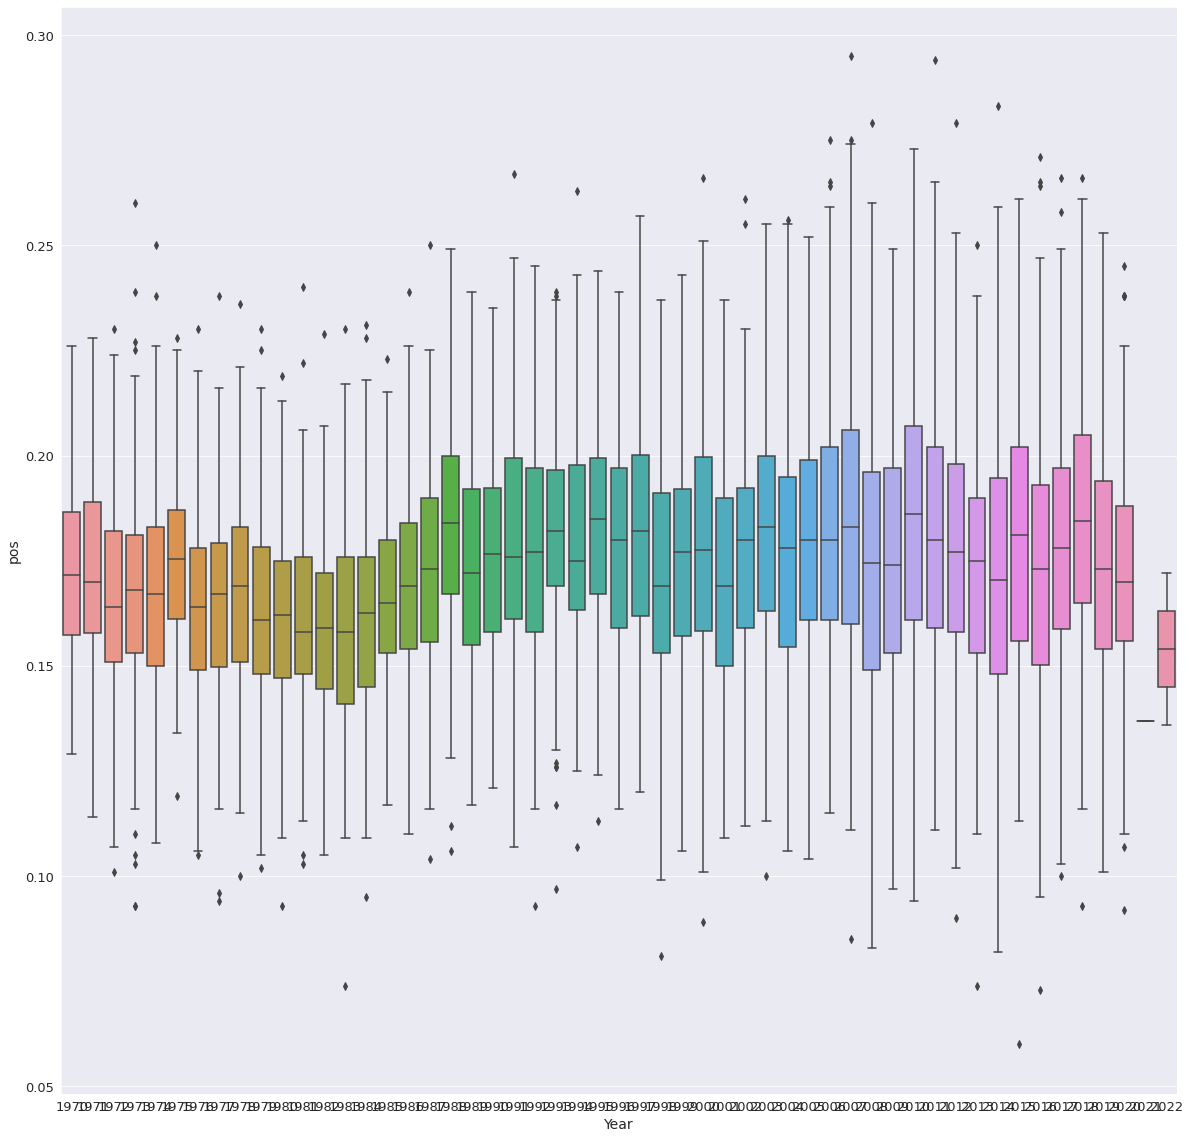

In [4]:
plt.figure(figsize=(20,20))
df = df_un_merged.reset_index()
sns.boxplot(x=df['Year'], y=df['pos'] )


## Run bag of words

In [5]:
count_vect = CountVectorizer(lowercase=True, \
                             stop_words='english',\
                             analyzer='word',\
                            token_pattern=r"[a-z]+'?[a-z]+", \
                            min_df=100, ngram_range=(1,1))

count_vect_bigram = CountVectorizer(lowercase=True, \
                             stop_words='english',\
                             analyzer='word',\
                            token_pattern=r"[a-z]+'?[a-z]+", \
                            min_df=100, ngram_range=(2,2))

X_counts = count_vect.fit_transform(df_un_merged["Speech"])
X_counts_bigram = count_vect_bigram.fit_transform(df_un_merged["Speech"])

X_counts_tf = TfidfTransformer(use_idf=True).fit_transform(X_counts)
words_list = count_vect.get_feature_names_out()
words_list_bigram = count_vect_bigram.get_feature_names_out()
X_counts = pd.DataFrame(X_counts.toarray(), columns=words_list)
X_counts_bigram = pd.DataFrame(X_counts_bigram.toarray(), columns=words_list_bigram)
#X_counts = pd.DataFrame(X_counts_tf.toarray(), columns=words_list)

# EDA

In [6]:
amount_of_words = X_counts.sum().sort_values(ascending=False)
amount_of_words_bigram = X_counts_bigram.sum().sort_values(ascending=False)

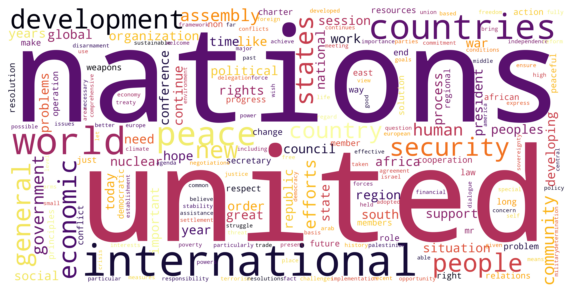

In [7]:
cloud = WordCloud(scale = 10, random_state = 1, max_font_size=100, background_color="white", colormap="inferno")\
.generate_from_frequencies(amount_of_words)

plt.figure(figsize=(10,10))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

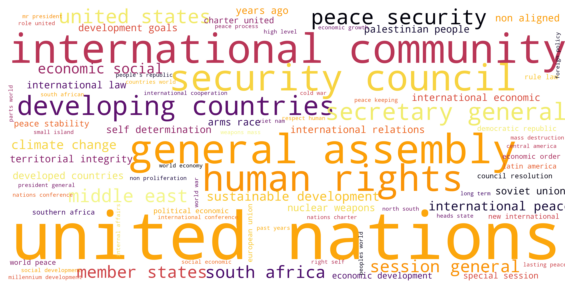

In [8]:
cloud = WordCloud(scale = 10, random_state = 1, max_font_size=100, background_color="white", colormap="inferno")\
.generate_from_frequencies(amount_of_words_bigram)

plt.figure(figsize=(10,10))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

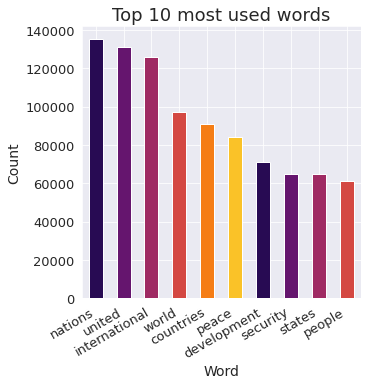

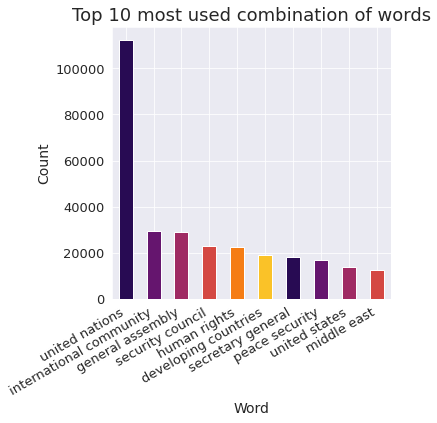

In [9]:
plt.figure(figsize=(5,5))

colors = sns.color_palette('inferno')

amount_of_words[0:10].plot.bar(color = colors)
plt.xticks(rotation=30, ha = 'right')
plt.xlabel("Word")
plt.ylabel("Count")
plt.title("Top 10 most used words")

plt.figure(figsize=(5,5))

amount_of_words_bigram[0:10].plot.bar(color = colors)
plt.xticks(rotation=30, ha = 'right')
plt.xlabel("Word")
plt.ylabel("Count")
plt.title("Top 10 most used combination of words")
plt.show()

## Merge UNGDC with bag of words

In [10]:
df_un_merged = df_un_merged.reset_index().merge(X_counts, how='left', left_index=True, right_index=True)
df_un_merged.set_index(['Year','ISO-alpha3 Code'], inplace=True)


## Read happiness report and merge with country codes to get ISO-alpha3 Code

In [11]:
happinessdataframe = pd.read_excel('DataForTable2.1.xls')
df_happiness_merged = happinessdataframe.merge(df_codes[['Country or Area','ISO-alpha3 Code']], how='left', left_on='Country name', right_on='Country or Area')
df_happiness_merged.set_index(['year','ISO-alpha3 Code'], inplace=True)
df_happiness_merged.index.rename(['Year','ISO-alpha3 Code'], inplace=True)
df_happiness_merged.drop(columns=['Country name','Country or Area'], inplace=True)

## Read HDI report

In [12]:
HDI = pd.read_csv('HDI2.csv', sep=';')
HDI.drop(columns=['region','country'],inplace=True)
HDI = HDI.melt(id_vars=['iso3'], var_name='Year', value_name='Human Development Index (UNDP)')
HDI['Year'] = HDI['Year'].astype(int)
HDI.sort_values(by=['Year'], inplace = True)
HDI.set_index(['Year', 'iso3'], inplace = True)
HDI.index.rename(['Year','ISO-alpha3 Code'], inplace=True)


In [13]:
# HDI = pd.read_csv('HDI.csv')
# HDI.sort_values(by=['Year'], inplace = True)
# HDI.set_index(['Year', 'Code'], inplace = True)
# HDI.drop(columns=['Entity'], inplace=True)
# HDI.index.rename(['Year','ISO-alpha3 Code'], inplace=True)
# HDI.loc[1990,:,:]

## Merge UNGDC with happiness report and HDI by Multiple index Year, ISO

In [14]:
df_merged = df_un_merged.merge(df_happiness_merged, how='left', left_index=True, right_index=True)
df_merged = df_merged.merge(HDI, how='left', left_index=True, right_index=True)
df_merged.dropna(subset=['Human Development Index (UNDP)'])

Session  \
Year ISO-alpha3 Code            
1990 AFG                   45   
     ALB                   45   
     ARE                   45   
     ARG                   45   
     AUS                   45   
...                       ...   
2020 YEM                   75   
     ZAF                   75   
     ZMB                   75   
     ZWE                   75   
2021 UKR                   76   

                                                                 Speech  \
Year ISO-alpha3 Code                                                      
1990 AFG              ﻿allow me, first of all, sir, to congratulate ...   
     ALB              ﻿it is a special pleasure for me to speak at t...   
     ARE              ﻿\nmr. president, on behalf of the delegation ...   
     ARG              ﻿at the outset, let me convey to you, sir, my ...   
     AUS              ﻿it is with great pleasure. sir, that i congra...   
...                                                                 ...   
2020 YEM              in the name of god the merciful and the compas...   
     ZAF              president of the general assembly, secretary-g...   
     ZMB              your excellency mr. volkan bozkir, president o...   
     ZWE              your excellency, ambassador volkan bozkir, pre...   
2021 UKR              only pronounced in the un general assembly in ...   

                           Country or Area Region Name    neg    neu    pos  \
Year ISO-alpha3 Code                                                          
1990 AFG                       Afghanistan        Asia  0.109  0.762  0.129   
     ALB                           Albania      Europe  0.080  0.723  0.196   
     ARE              United Arab Emirates        Asia  0.123  0.721  0.156   
     ARG                         Argentina    Americas  0.069  0.756  0.175   
     AUS                         Australia     Oceania  0.083  0.718  0.199   
...                                    ...         ...    ...    ...    ...   
2020 YEM                             Yemen        Asia  0.093  0.714  0.193   
     ZAF                      South Africa      Africa  0.103  0.728  0.168   
     ZMB                            Zambia      Africa  0.042  0.749  0.210   
     ZWE                          Zimbabwe      Africa  0.046  0.772  0.182   
2021 UKR                           Ukraine      Europe  0.084  0.779  0.137   

                      compound  ababa  abandon  ...  Log GDP per capita  \
Year ISO-alpha3 Code                            ...                       
1990 AFG                0.9885      0        0  ...                 NaN   
     ALB                0.9999      0        0  ...                 NaN   
     ARE                0.9977      0        0  ...                 NaN   
     ARG                0.9998      0        0  ...                 NaN   
     AUS                1.0000      0        0  ...                 NaN   
...                        ...    ...      ...  ...                 ...   
2020 YEM                0.9991      0        0  ...                 NaN   
     ZAF                0.9984      0        0  ...            9.446663   
     ZMB                0.9989      0        0  ...            8.094933   
     ZWE                0.9995      0        0  ...            8.117733   
2021 UKR                0.9993      0        0  ...            9.462497   

                      Social support  Healthy life expectancy at birth  \
Year ISO-alpha3 Code                                                     
1990 AFG                         NaN                               NaN   
     ALB                         NaN                               NaN   
     ARE                         NaN                               NaN   
     ARG                         NaN                               NaN   
     AUS                         NaN                               NaN   
...                              ...                               ...   
2020 YEM            

## Select only 2005-2020

In [29]:
df_merged_05_20 = df_merged.loc[2005:,:] 


In [26]:
set(df_merged_05_20['Region Name'])

{'Africa', 'Americas', 'Asia', 'Europe', 'Oceania', nan}

nr European countries: 44
nr African countries: 54
nr American countries: 35
nr Asian countries: 48
nr Oceanean countries: 14


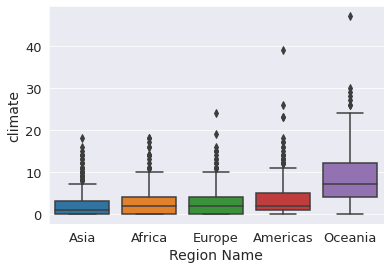

In [17]:
#Group dataset by region
sns.boxplot( x=df_merged_05_20['Region Name'], y=df_merged_05_20['climate'] )

eur = df_merged_05_20[df_merged_05_20['Region Name'] == 'Europe']
afr = df_merged_05_20[df_merged_05_20['Region Name'] == 'Africa']
ame = df_merged_05_20[df_merged_05_20['Region Name'] == 'Americas']
asi = df_merged_05_20[df_merged_05_20['Region Name'] == 'Asia']
oce = df_merged_05_20[df_merged_05_20['Region Name'] == 'Oceania']

print('nr European countries:', eur['Country or Area'].nunique())
print('nr African countries:', afr['Country or Area'].nunique())
print('nr American countries:', ame['Country or Area'].nunique())
print('nr Asian countries:', asi['Country or Area'].nunique())
print('nr Oceanean countries:', oce['Country or Area'].nunique())

#Group by means per year
eur_means = eur.groupby('Year').aggregate(np.nanmean)
afr_means = afr.groupby('Year').aggregate(np.nanmean)
ame_means = ame.groupby('Year').aggregate(np.nanmean)
asi_means = asi.groupby('Year').aggregate(np.nanmean)
oce_means = oce.groupby('Year').aggregate(np.nanmean)

#Get the count of the usage of the word 'climate' in speeches
eur_climate = eur[['climate']].groupby('Year').mean()
afr_climate = afr[['climate']].groupby('Year').mean()
ame_climate = ame[['climate']].groupby('Year').mean()
asi_climate = asi[['climate']].groupby('Year').mean()
oce_climate = oce[['climate']].groupby('Year').mean()



## Create speeches countplot per region from 2005 to 2020

Text(0, 0.5, 'Mean count')

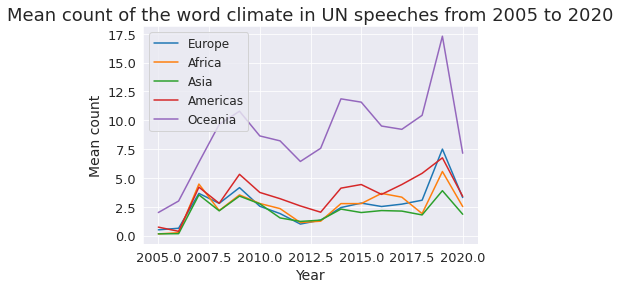

In [18]:
#Plot per region (absolute counts)
plt.plot(eur_climate, label = "Europe")
plt.plot(afr_climate, label = "Africa")
plt.plot(asi_climate, label = "Asia")
plt.plot(ame_climate, label = "Americas")
plt.plot(oce_climate, label = "Oceania")
plt.legend(loc=2, prop={'size': 12})
plt.title(label = 'Mean count of the word climate in UN speeches from 2005 to 2020')
plt.xlabel('Year')
plt.ylabel('Mean count')

# #Plot per region (relative counts to nr of countries per region)
# plt.plot(eur_climate / eur['Country or Area'].nunique(), label = "Europe")
# plt.plot(afr_climate / afr['Country or Area'].nunique(), label = "Africa")
# plt.plot(asi_climate / asi['Country or Area'].nunique(), label = "Asia")
# plt.plot(ame_climate / ame['Country or Area'].nunique(), label = "Americas")
# plt.plot(oce_climate / oce['Country or Area'].nunique(), label = "Oceania")
# plt.legend(loc=2, prop={'size': 12})
# plt.title(label = 'Mean count of the word climate in UN speeches from 2005 to 2020')
# plt.xlabel('Year')
# plt.ylabel('Mean count')

Text(0, 0.5, 'Human Development Index')

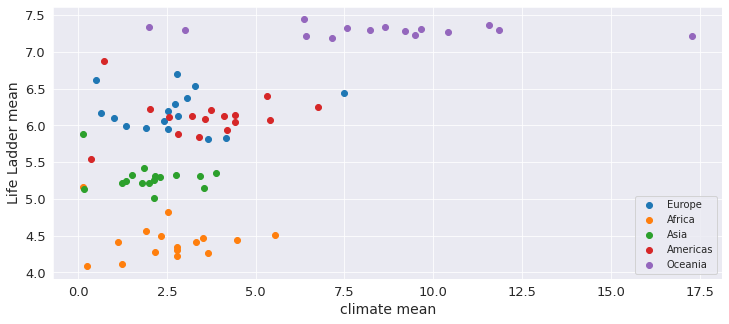

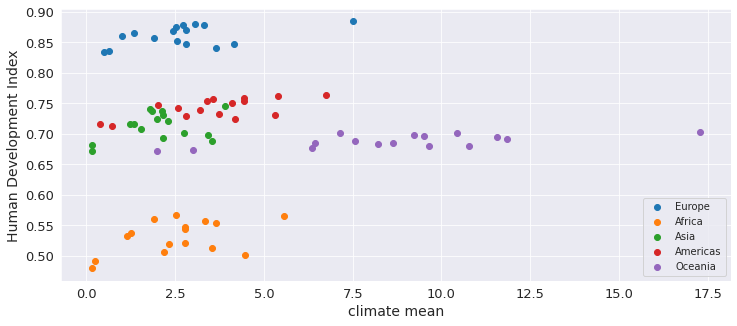

In [19]:
plt.figure(figsize=(12,5))
plt.scatter(eur_climate['climate'], eur_means['Life Ladder'], label = "Europe")
plt.scatter(afr_climate['climate'], afr_means['Life Ladder'], label = "Africa")
plt.scatter(asi_climate['climate'], asi_means['Life Ladder'], label = "Asia")
plt.scatter(ame_climate['climate'], ame_means['Life Ladder'], label = "Americas")
plt.scatter(oce_climate['climate'], oce_means['Life Ladder'], label = "Oceania")
plt.legend(loc=4, prop={'size': 10})
plt.xlabel('climate mean')
plt.ylabel('Life Ladder mean')

plt.figure(figsize=(12,5))
plt.scatter(eur_climate['climate'], eur_means['Human Development Index (UNDP)'], label = "Europe")
plt.scatter(afr_climate['climate'], afr_means['Human Development Index (UNDP)'], label = "Africa")
plt.scatter(asi_climate['climate'], asi_means['Human Development Index (UNDP)'], label = "Asia")
plt.scatter(ame_climate['climate'], ame_means['Human Development Index (UNDP)'], label = "Americas")
plt.scatter(oce_climate['climate'], oce_means['Human Development Index (UNDP)'], label = "Oceania")
plt.legend(loc=4, prop={'size': 10})
plt.xlabel('climate mean')
plt.ylabel('Human Development Index')

In [20]:
lst1 = [eur.shape[0], afr.shape[0], asi.shape[0], ame.shape[0], oce.shape[0]]
lst2 = [eur['Country or Area'].nunique(), afr['Country or Area'].nunique(), asi['Country or Area'].nunique(), ame['Country or Area'].nunique(), oce['Country or Area'].nunique()]

speeches_count_regions = pd.DataFrame(list(zip(lst1, lst2)), columns = ['Number of speeches', 'Number of countries'], index = ['Europe', 'Africa', 'Asia', 'Americas', 'Oceania'])
speeches_count_regions

,Number of speeches,Number of countries
Europe,701,44
Africa,838,54
Asia,752,48
Americas,559,35
Oceania,224,14


## Create plots for Life ladder, GDP and HDI

([<matplotlib.axis.XTick at 0x7faabdb81eb0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

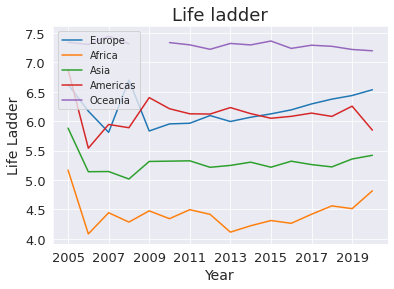

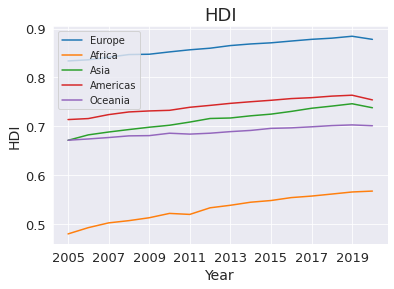

In [21]:
#Plots of happiness indicators
plt.figure(1)
plt.plot(eur_means['Life Ladder'], label = "Europe")
plt.plot(afr_means['Life Ladder'], label = "Africa")
plt.plot(asi_means['Life Ladder'], label = "Asia")
plt.plot(ame_means['Life Ladder'], label = "Americas")
plt.plot(oce_means['Life Ladder'], label = "Oceania")
plt.legend(loc=2, prop={'size': 10})
plt.title(label = 'Life ladder')
plt.xlabel('Year')
plt.ylabel('Life Ladder')
plt.xticks(np.arange(2005, 2020, step=2))

# plt.plot(eur_means['Log GDP per capita'], label = "Europe")
# plt.plot(afr_means['Log GDP per capita'], label = "Africa")
# plt.plot(asi_means['Log GDP per capita'], label = "Asia")
# plt.plot(ame_means['Log GDP per capita'], label = "Americas")
# plt.plot(oce_means['Log GDP per capita'], label = "Oceania")
# plt.legend(loc=2, prop={'size': 10})
# plt.title(label = 'Log GDP')
# plt.xlabel('Year')
# plt.ylabel('Log GDP')
# plt.xticks(np.arange(2005, 2020, step=2))
plt.figure(2)

plt.plot(eur_means['Human Development Index (UNDP)'], label = "Europe")
plt.plot(afr_means['Human Development Index (UNDP)'], label = "Africa")
plt.plot(asi_means['Human Development Index (UNDP)'], label = "Asia")
plt.plot(ame_means['Human Development Index (UNDP)'], label = "Americas")
plt.plot(oce_means['Human Development Index (UNDP)'], label = "Oceania")
plt.legend(loc=2, prop={'size': 10})
plt.title(label = 'HDI')
plt.xlabel('Year')
plt.ylabel('HDI')
plt.xticks(np.arange(2005, 2020, step=2))


### Split data set

Oceania test 8
Oceania train 8
Oceania valid 12


best aparmeters {'max_depth': 5}
f1 score: [0.72857143 0.58227848 0.7027027  0.         0.4620462 ]
Oceania test 8
Oceania train 8
Oceania valid 12


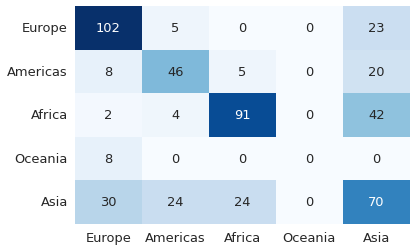

In [67]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

features=['Human Development Index (UNDP)', 'climate', 'Life Ladder']
# features=['Human Development Index (UNDP)', 'climate']
# features=[ 'climate', 'Life Ladder']
df = df_merged_05_20.dropna(subset=features)
df = df.dropna(subset='Region Name')

x=df
y=x['Region Name']
categories = ['Europe', 'Americas', 'Africa', 'Oceania', 'Asia']


# splitting the data
x_rem, x_test, y_rem, y_test = train_test_split(x, y, test_size=0.3, random_state = 42)
x_train, x_valid, y_train, y_valid = train_test_split(x_rem, y_rem, test_size=0.3, random_state = 42)
clf = DecisionTreeClassifier(random_state=10)

### Hyperparameters tunning based grid search on validation data set
# Create grid of parameters to test through cross-validation
param_grid = {'max_depth': np.arange(3,10) }
grid = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')
grid.fit(x_valid[features], y_valid)

### Fit the best estimator on the train set
grid.best_estimator_.fit(x_train[features], y_train)
print("best aparmeters" ,grid.best_params_)
y_pred = grid.best_estimator_.predict(x_test[features])
conf_mat = confusion_matrix(y_test, y_pred, labels=categories)
sns.heatmap(conf_mat, annot=True, xticklabels=categories, yticklabels=categories, cbar=False,
            fmt='d', cmap='Blues')

print("f1 score:",f1_score(y_test, y_pred, average=None, labels=categories))
print('Oceania rows in test',y_test[y_test=='Oceania'].count())
print('Oceania rows train',y_train[y_train=='Oceania'].count())
print('Oceania rows valid',y_valid[y_valid=='Oceania'].count())

### plot tree

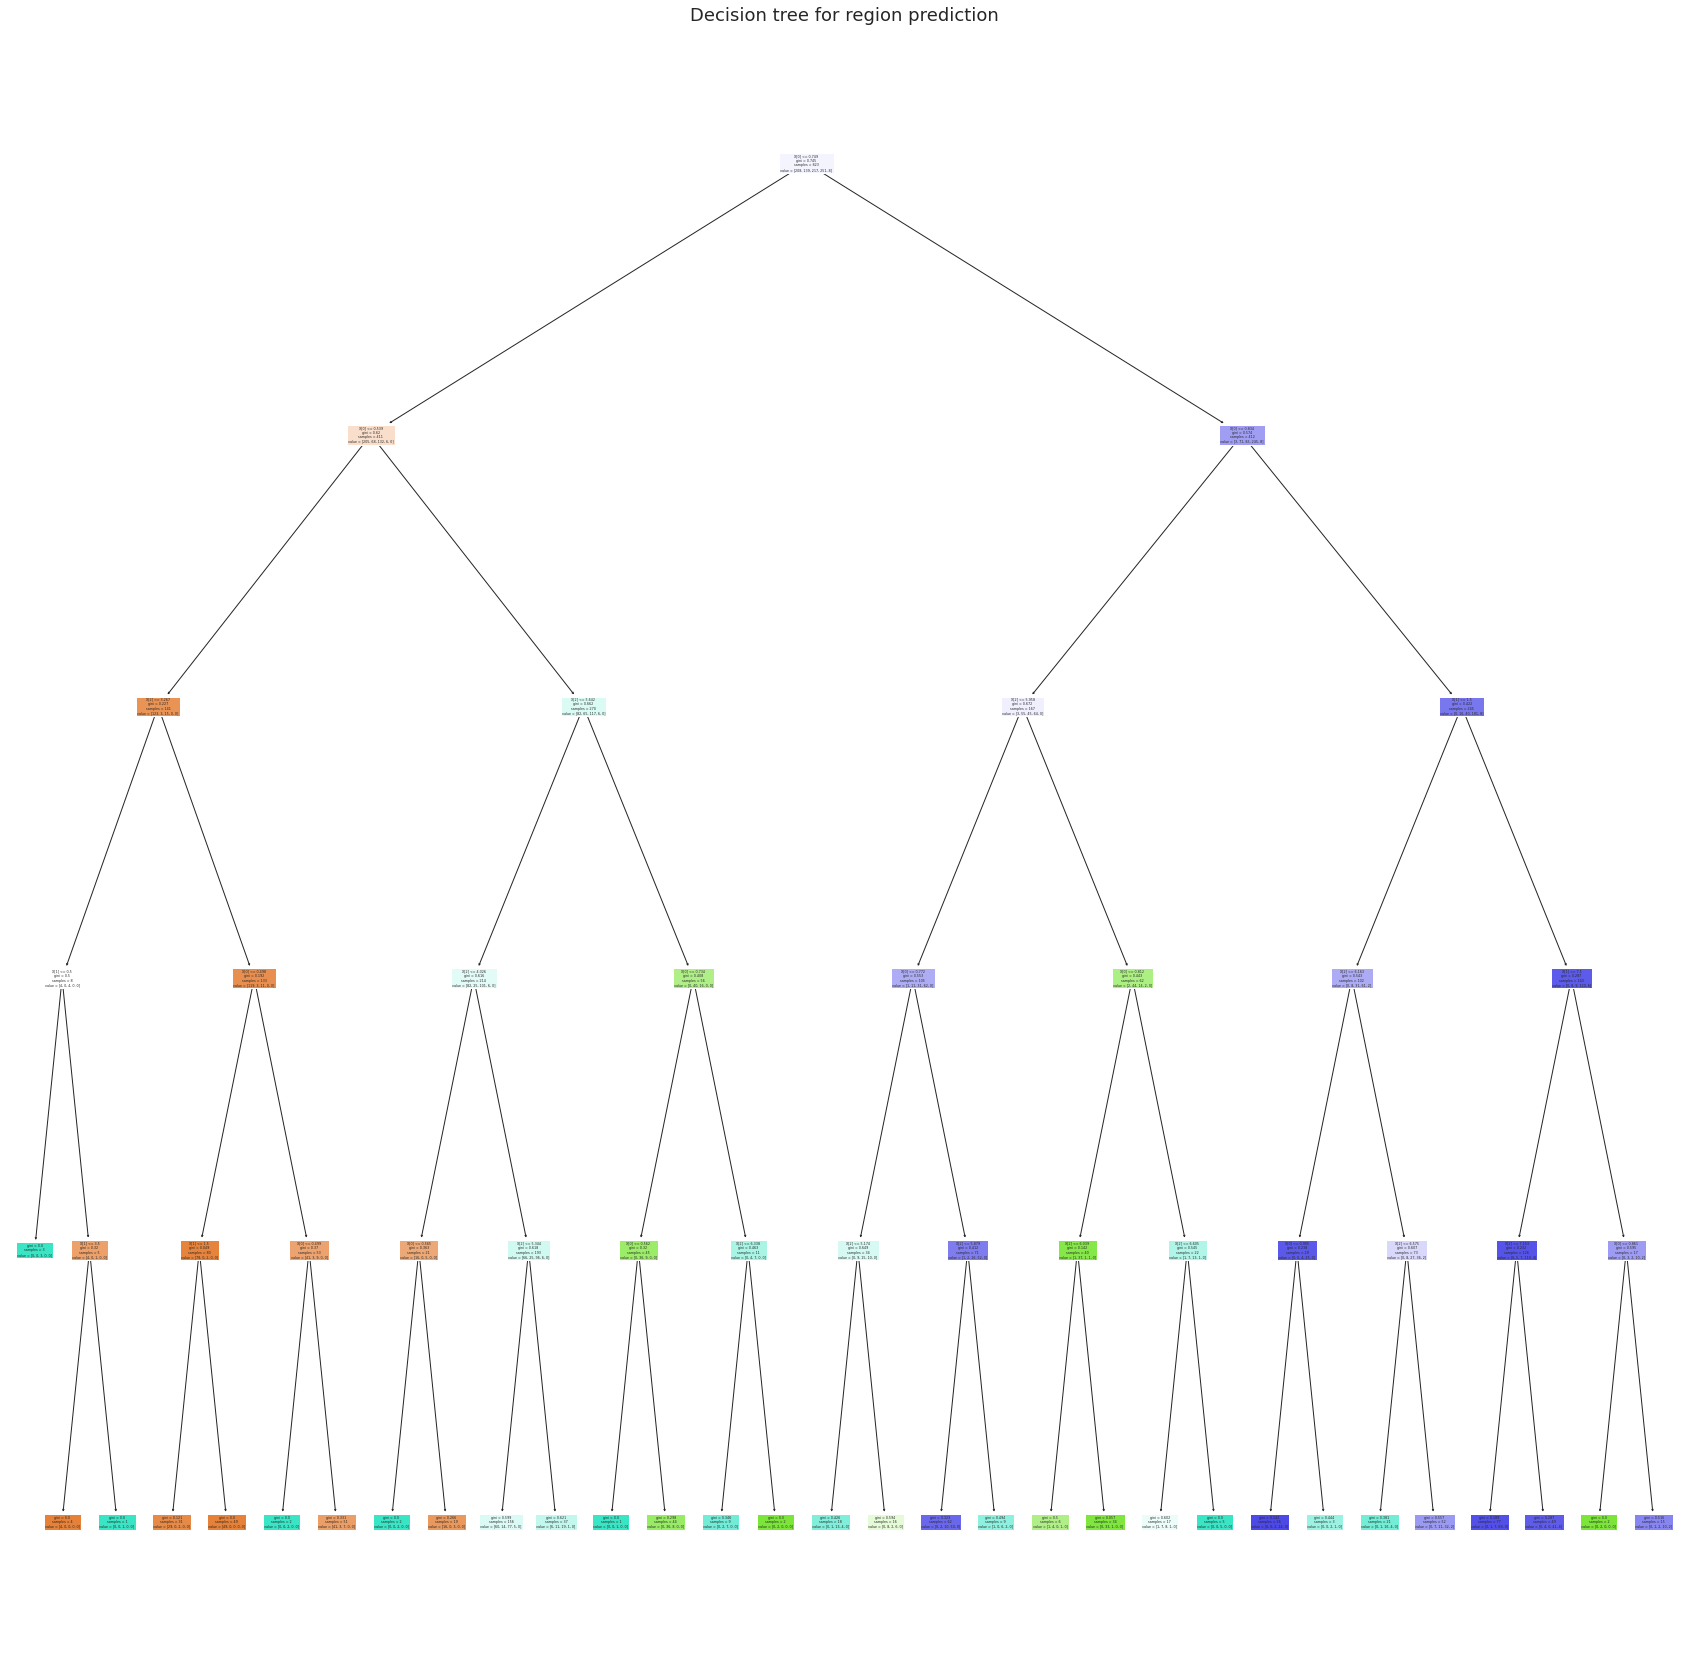

In [47]:
from sklearn.tree import plot_tree

plt.figure(figsize=(30,30))
plot_tree(grid.best_estimator_, filled=True)
plt.title("Decision tree for region prediction")
plt.show()